In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import glob
import scipy
import cv2


from scipy.optimize import curve_fit
from tools.tools import *


In [131]:
# root = "./configs"

radius = 5.5e-6 #Bead size m
rho = 1.3 * 1000 #Bead density kg/m^3
mu_0 = 4*np.pi*1e-7 #permeability
phase = 5

time_s = 80; time_e = 300
m = 3.5/(10*0.3*3.3)*1e-6

T_0 = 25
r_T_0 = 0.971e3
v = 30000e-6

# Silicone oil temperature dependence
T = 23
a = 9.2e-4
b = 4.5e-7
r_ = r_T_0/(1+a*(T-T_0)+b*(T-T_0)**2)
nn = v*r_

#Parameters to crop simulation
height = 1544*m #height of FoV in µm
width = 2064*m #width of FoV in µm

#Parameters to crop simulation
height = 1544*m #height of FoV in µm
width = 2064*m #width of FoV in µm

start_w =  0#0.0035 - width #flip
end_w = width

start_h = 0.003 - height/2; end_h = 0.003 + height/2

c:\Users\lehto\git\OneCoilMicroRheometer\Analysis\tools\tools.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  return x/(1/x_0 + np.abs(x)/H_sat)
c:\Users\lehto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lehto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


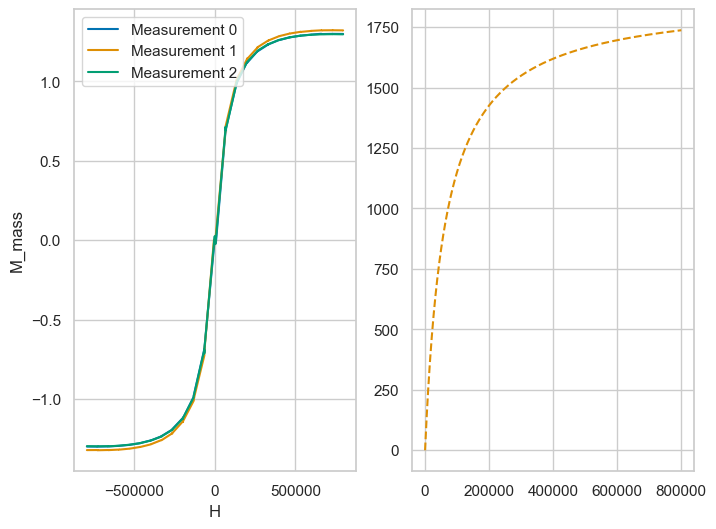

In [132]:
root = "./data"
paths = glob.glob(os.path.join(root,"*.dat"))

df_bead = []

for count,i in enumerate(paths):
    ending = i.split("\\")[-1]
    parts = ending.split("_")
    day = parts[0]
    weight = float(parts[2][:-6])*1e-6 #*0.0275

    df_sub = pd.read_csv(i, sep= ",", skiprows = np.arange(0,34), encoding='latin-1').iloc[1:, :].dropna(how='all', axis = "columns")
    df_sub["sample"] = count
    df_sub["weight"] = weight

    #Oe  1/(4pi)*10^3 A/m
    df_sub["H"] = df_sub["Magnetic Field (Oe)"] * 1/(4*np.pi)*1e3
    #= 1 emu 10−3 A·m2
    df_sub["moment"] = df_sub["Moment (emu)"]*1e-3

    start_sat = np.where(df_sub["H"][:125].values>600e3)[0][0]
    end_sat = np.argmax(df_sub["H"][:125].values)

    k = np.polyfit(df_sub["H"][start_sat:end_sat].values,df_sub["moment"][start_sat:end_sat].values-df_sub["moment"][start_sat:end_sat].values[0],deg = 1, cov = False)
    offset = k[0]*df_sub["H"]

    df_sub["moment"] = df_sub["moment"] - offset
    df_sub["M_mass"] = df_sub["moment"]/(weight)
    df_sub["Measurement"] = f"Measurement {count}"

    if count == 0:
        df_bead = df_sub
    else:
        df_bead = pd.concat((df_bead,df_sub))


df_bead = df_bead.reset_index(drop=True)
df_stored = df_bead.copy().reset_index(drop=True)

df_stored["H"] = df_stored["H"].round(-1)
df_stored["M"] = df_stored["M_mass"]* rho

df_bead["H_round"] = np.round(df_bead["H"].values, -5)
fd_mean = df_bead.groupby(["H_round"]).mean(numeric_only=True).reset_index()
mask = fd_mean["H"].values >= 0
xdata = np.linspace(0,800000,1000)
popt, pcov = curve_fit(func_Fk, fd_mean["H_round"][mask], fd_mean["M_mass"][mask], method = "dogbox", bounds = [[0,0],[10,np.inf]])
ydata = func_Fk(xdata, *popt)

M_mag = ydata*rho
B_mag = xdata*mu_0


fig, ax = plt.subplots(1,2, figsize=(8,6))
sns.lineplot(x = "H", y = "M_mass", data = df_stored, hue = "Measurement", ax=ax[0], errorbar="sd")
ax[0].legend(title="", loc = "upper left") 
ax[1].plot(xdata, M_mag, "--", color = "C1")
# ax[0].set_xlabel("Magnetic field H (A/m)")
plt.show()

c:\Users\lehto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lehto\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


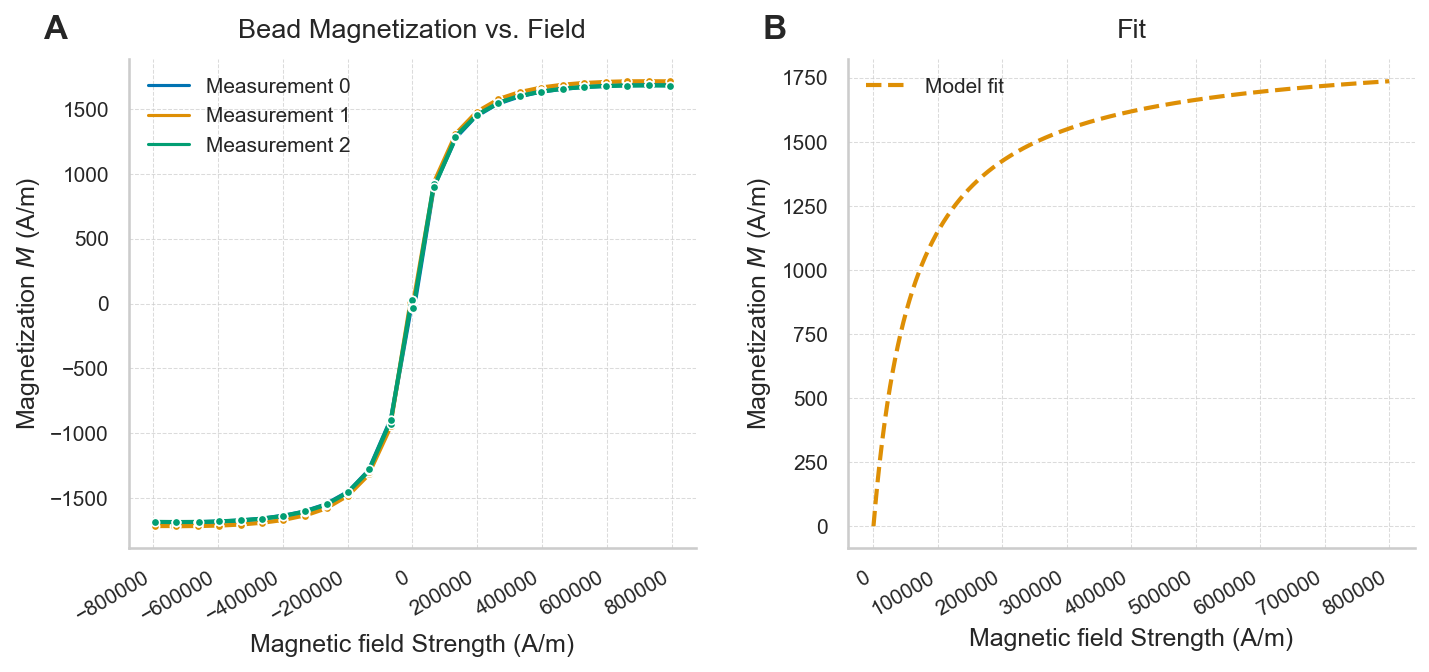

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
sns.lineplot(x="H", y="M", data=df_stored, hue="Measurement", ax=ax[0], errorbar="sd", linewidth=2, marker="o", markersize=4, palette="colorblind")
ax[0].legend(title="", loc="upper left", frameon=False, fontsize=10)
ax[0].set_xlabel("Magnetic field Strength (A/m)", fontsize=12)
ax[0].set_ylabel("Magnetization $M$ (A/m)", fontsize=12)
ax[0].set_title("Bead Magnetization vs. Field", fontsize=13, pad=10)
ax[0].tick_params(axis='both', which='major', labelsize=10)
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

for label in ax[0].get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')

ax[1].plot(xdata, M_mag, "--", color="C1", linewidth=2, label="Model fit")
ax[1].set_xlabel("Magnetic field Strength (A/m)", fontsize=12)
ax[1].set_ylabel("Magnetization $M$ (A/m)", fontsize=12)
ax[1].set_title("Fit", fontsize=13, pad=10)
ax[1].tick_params(axis='both', which='major', labelsize=10)
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
for label in ax[1].get_xticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment('right')
ax[1].legend(frameon=False, fontsize=10)

add_panel_labels(ax, xy=(-0.15, 1.09), fontsize=16)

plt.tight_layout(pad=2)
sns.despine()
plt.show()

In [134]:

def load_simulation(path, time_stamps, di = 1):

    global start_w, end_w, start_h, end_h, frame
    
    if not time_stamps:
        columns_ = ["x", "y", "By", "Bx"]
        df_sim = pd.read_csv(path, sep = ",", skiprows= np.arange(0,8))
        df_sim.columns =columns_
    else:
        df_sim = pd.read_csv(path, sep = ",", skiprows= np.arange(0,8))
        columns_ = ["x","y"]

        for i in (np.arange((df_sim.shape[1]-2)//2)):
            columns_.append("Bx_{}".format(i))
            columns_.append("By_{}".format(i))

        df_sim.columns = columns_    

    field_dict = {"xx__":[], "yy__":[],  "X1": [], "Y1":[], "B": {}, "dBx":{},  "dBy":{}}

    df_sim["x"] = np.round(df_sim["x"], 5) #- (0.0035 - width)
    df_sim["y"] = np.round(df_sim["y"], 5) #- (0.003 - height/2)
    map_x = df_sim["x"].values
    map_y = df_sim["y"].values
    field_dict["xx__"] = np.linspace(start_w,end_w, frame.shape[1]) #- (0.0035 - width)
    field_dict["yy__"] = np.linspace(start_h,end_h, frame.shape[0]) #- (0.003 - height/2)
    y_unique = np.unique(map_y) 
    x_unique = np.unique(map_x) 
    y_u = len(np.unique(map_y))
    x_u = len(np.unique(map_x))
    
    field_dict["y_coord"] = np.concatenate((x_unique, x_unique[1:]+np.max(x_unique))) - start_h 
    field_dict["x_coord"] = y_unique + -1*np.min(y_unique)
    
    field_dict["X1"], field_dict["Y1"] = np.meshgrid(field_dict["x_coord"], field_dict["y_coord"])

    for idx, i in enumerate(zip(columns_[2::2], columns_[3::2])):
        df_sim[i[0]] = scipy.ndimage.gaussian_filter1d(df_sim[i[0]].values,5) 
        df_sim[i[1]] = scipy.ndimage.gaussian_filter1d(df_sim[i[1]].values,5)
        
        df_sim["B_{}".format(idx)] = np.sqrt((df_sim[i[0]].values)**2 +  df_sim[i[1]].values**2)

        B = df_sim["B_{}".format(idx)].values    
        B = B.reshape((y_u, x_u))
        B = np.rot90(B, k=-1)
        BB = np.vstack((B[::-1,:], B[1:,:]))

        field_dict["B"]["B_{}".format(idx)] = scipy.ndimage.gaussian_filter(BB, 5)
        field_dict["dBx"]["dBx_{}".format(idx)] = scipy.ndimage.gaussian_filter(np.gradient(field_dict["B"]["B_{}".format(idx)], 1e-5, axis  = 1),5)#*np.sin(angle)
        field_dict["dBy"]["dBy_{}".format(idx)] = scipy.ndimage.gaussian_filter(np.gradient(field_dict["B"]["B_{}".format(idx)], 1e-5, axis  = 0),5)#*np.cos(angle)

    return field_dict, df_sim

def calc_force(dB, B ):
    global radius
    sim_force_martrix = np.zeros_like(dB)
    volume = 4/3 * np.pi * radius**3

    for i in range(dB.shape[0]):
        for j in range(dB.shape[1]):
            M_B = M_mag[np.argmin(np.abs(B_mag-B[i,j]))]  #B_mag, M_mag)
            sim_force_martrix[i,j] = volume*M_B*dB[i,j]

    sim_force_martrix = scipy.ndimage.gaussian_filter(sim_force_martrix, 5)

    return sim_force_martrix

In [135]:
import cv2
#Download frame for visualization glitter
path_vid = glob.glob("./results/current_response/*.mp4")

cap = cv2.VideoCapture(path_vid[0])
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        #frame = cv2.flip(frame,0)
        break

test_frame = 255-cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

path = "./data/One_coil_dense_t_angle.csv"
field_dict, df_sim = load_simulation(path, time_stamps=True, di=1)

# field_dict["X1"], field_dict["Y1"] = np.meshgrid(field_dict["x_coord"], field_dict["y_coord"])

field_matrix = []
grad_field_matrix = []
for key, i in field_dict["B"].items():
    field_matrix.append(i)

for (key_x, i_x), (key_y, i_y) in zip(field_dict["dBx"].items(), field_dict["dBy"].items()):
    grad_field_matrix.append(np.sqrt(i_x**2 + i_y**2))


field_matrix = np.stack(field_matrix, axis=2)
grad_field_matrix = np.stack(grad_field_matrix, axis=2)

force_control_matrix = np.zeros_like(grad_field_matrix)

for i in range(force_control_matrix.shape[-1]):
    force_control_matrix[:,:,i] = calc_force(grad_field_matrix[:,:,i], field_matrix[:,:,i])


X1 = field_dict["X1"]
Y1 = field_dict["Y1"]   
xx__ = field_dict["xx__"] #- (0.0035 - width)
yy__ = field_dict["yy__"] #- (0.003 - height/2)

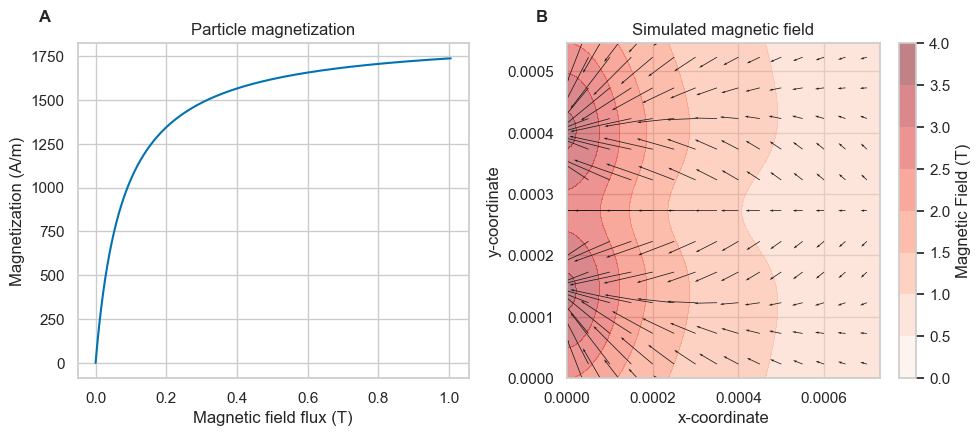

In [136]:
phase = 5
level = 5

fig = plt.figure(figsize = (10,8))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

ax2.contourf(xx__, yy__, test_frame, alpha = 1, cmap="binary")
CS = ax2.contourf(field_dict["x_coord"], field_dict["y_coord"], field_matrix[:,:,level], alpha = 0.5, cmap = "Reds")
ax2.quiver(X1[::phase, ::phase], Y1[::phase, ::phase], field_dict["dBx"]["dBx_{}".format(level)][::phase,::phase], field_dict["dBy"]["dBy_{}".format(level)][::phase,::phase], angles = "xy") #dBy[::phase,::phase],dBx[::phase,::phase]

end_h_ = end_h - start_h
start_h_ = start_h - start_h

ax2.set_xlim([start_w,end_w])
ax2.set_ylim([start_h_,end_h_])

ax1.plot(B_mag, M_mag)
ax1.set_title("Particle magnetization")
ax1.set_xlabel("Magnetic field flux (T)")
ax1.set_ylabel("Magnetization (A/m)")

ax2.set_title("Simulated magnetic field")
ax2.set_xlabel("x-coordinate")
ax2.set_ylabel("y-coordinate")

cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Magnetic Field (T)')

add_panel_labels([ax1, ax2])
plt.tight_layout()


#fig.savefig('./figures/forces.png') 

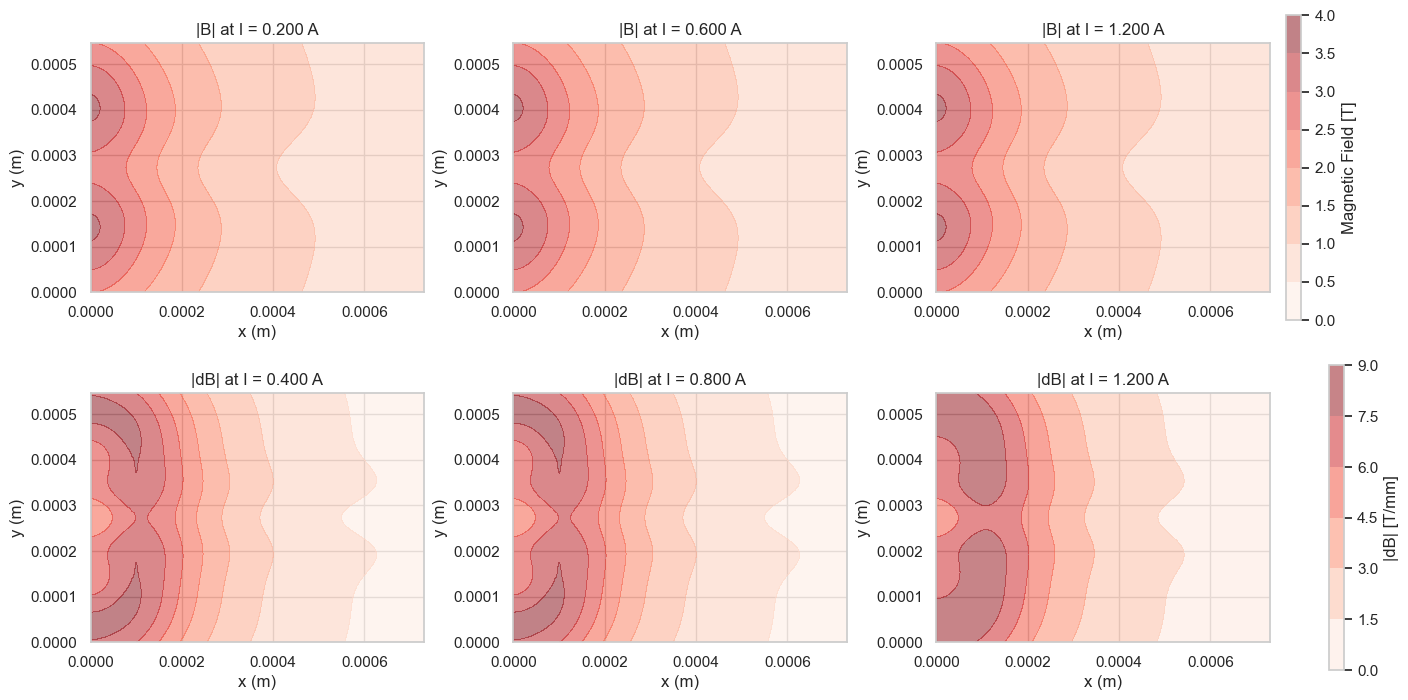

In [137]:
i_g =np.arange(0.2,1.4, 0.2)

fig, axes = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)

end_h_ = end_h - start_h
start_h_ = start_h - start_h

# KRR row
for col, k in enumerate([0,2,5]):
    CS = axes[0, col].contourf(field_dict["x_coord"], field_dict["y_coord"], field_matrix[:,:,level], alpha = 0.5, cmap = "Reds")
    axes[0, col].set_title(f"|B| at I = {i_g[k]:.3f} A")
    axes[0, col].set_xlabel("x (m)")
    axes[0, col].set_ylabel("y (m)")
    axes[0, col].set_aspect('equal', adjustable='box')
    axes[0, col].set_ylim([start_h_,end_h_])
    axes[0, col].set_xlim([start_w,end_w])

cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Magnetic Field [T]')

# GPR row
for col, k in enumerate([1,3,5]):
    cs_gpr = axes[1, col].contourf(field_dict["x_coord"], field_dict["y_coord"], grad_field_matrix[:,:,k]*1e-3, alpha = 0.5, cmap = "Reds")
    axes[1, col].set_title(f"|dB| at I = {i_g[k]:.3f} A")
    axes[1, col].set_xlabel("x (m)")
    axes[1, col].set_ylabel("y (m)")
    axes[1, col].set_aspect('equal', adjustable='box')
    axes[1, col].set_ylim([start_h_,end_h_])
    axes[1, col].set_xlim([start_w,end_w])

# Shared colorbars per row
fig.colorbar(cs_gpr, ax=axes[1, :], label="|dB| [T/mm]")

plt.show()

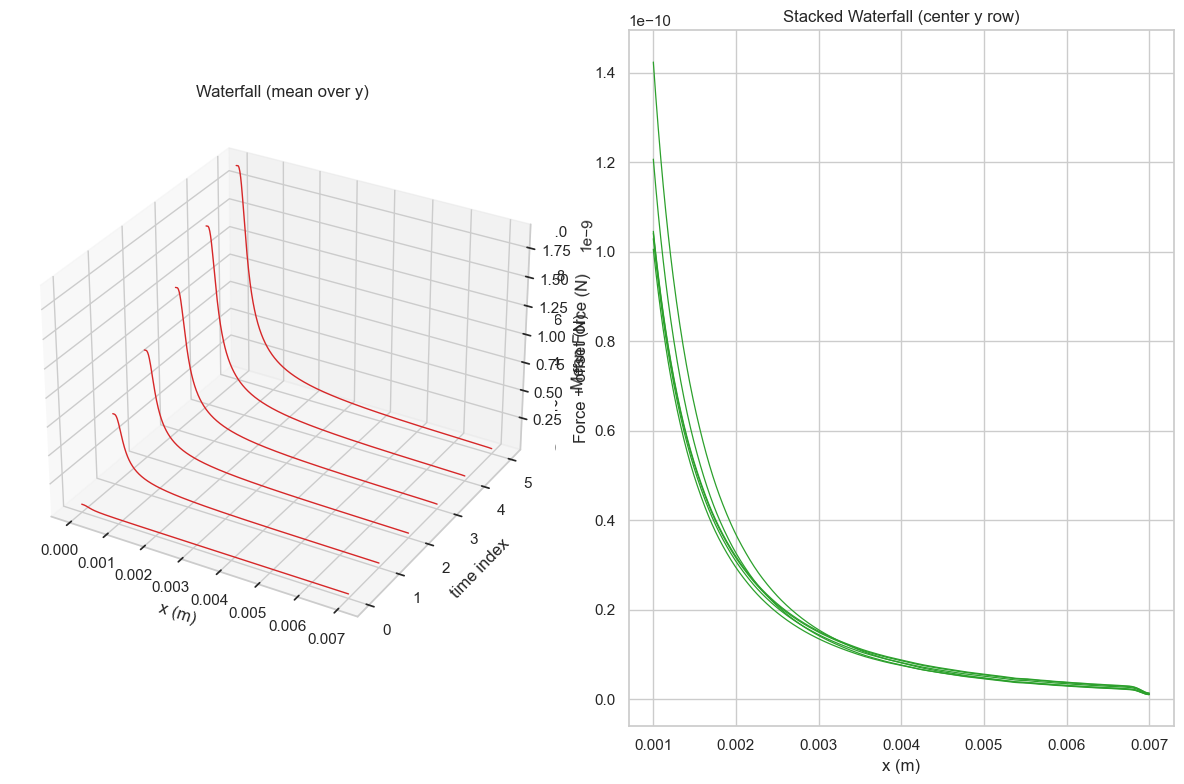

In [138]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(121, projection='3d')

X_line = field_dict["X1"][0, :]  # x axis along a row
y_idx = force_control_matrix.shape[0] // 2  # middle y row

n_t = force_control_matrix.shape[2]
step = max(1, n_t // 25)  # reduce number of lines

mean_force_x_t = force_control_matrix.mean(axis=0)  # (Nx, Nt)

ax = fig.add_subplot(121, projection='3d')
for k, t in enumerate(range(0, n_t, step)):
    line = mean_force_x_t[:, t]
    ax.plot(X_line, line, zs=t, zdir='y', color='tab:red', lw=1)

ax.set_xlabel('x (m)')
ax.set_ylabel('time index')
ax.set_zlabel('Mean Force (N)')
ax.set_title('Waterfall (mean over y)')
plt.tight_layout()

# 3. 2D stacked waterfall (projection)
ax1 = fig.add_subplot(122)
force_control_matrix_ = np.gradient(force_control_matrix, axis=2)
offset_step = (force_control_matrix_[y_idx, :, :].ptp()) * 0.15  # spacing
for t in range(0, n_t, step):

    line = force_control_matrix_[y_idx, :, t]
    ax1.plot(X_line[100:], line[100:], color='tab:green', lw=0.9)
    # ax1.text(X_line[-1], line[-1] + offset, f'{t}', va='center', fontsize=7)

ax1.set_xlabel('x (m)')
ax1.set_ylabel('Force + offset (N)')
ax1.set_title('Stacked Waterfall (center y row)')
plt.tight_layout()
plt.show()



In [144]:
from scipy.interpolate import interp1d

#interpolate to denser z-axis

z_old = np.linspace(0.2, 1.2, field_matrix.shape[-1])
Nz_new = 15
z_new = np.linspace(z_old.min(), z_old.max(), Nz_new)

# Interpolate along the 3rd axis
f_interp = interp1d(z_old, force_control_matrix, kind="linear", axis=2, bounds_error=False, fill_value="extrapolate")
force_control_matrix_dense = f_interp(z_new)  # shape (Ny, Nx, Nz_new)
force_control_matrix_grad_dense = np.gradient(force_control_matrix_dense, z_new, axis=2)


i_max = 1.2
xline = field_dict["X1"][0, :].copy()   # 1D x-axis values
yline = field_dict["Y1"][:, 0].copy()   # 1D y-axis values

x0 = np.searchsorted(xline, start_w, side="left")
x1 = np.searchsorted(xline, end_w,   side="right")
y0 = np.searchsorted(yline, start_h_, side="left")
y1 = np.searchsorted(yline, end_h_,   side="right")

force_control_matrix_dense_cropped = force_control_matrix_dense[y0:y1, x0:x1, :]  # (Ny', Nx', Nt)
force_control_matrix_grad_dense_cropped = force_control_matrix_grad_dense[y0:y1, x0:x1, :]

x_ticks_crop =  field_dict["X1"][0, :][x0:x1]
y_ticks_crop =  field_dict["Y1"][:, 0][y0:y1] #- y_shift
y_ticks_crop -= np.mean(y_ticks_crop)
i_axis = np.linspace(0.0, i_max, force_control_matrix_dense_cropped.shape[2])


In [145]:
import h5py

control_dict = {
    "model": {
        "force_field": force_control_matrix_dense_cropped.astype(np.float32),
        "F2I": force_control_matrix_grad_dense_cropped.astype(np.float32),
        "x": x_ticks_crop.astype(np.float64),
        "y": y_ticks_crop.astype(np.float64),
        "i": i_axis.astype(np.float64) }
}

with h5py.File("./results/force_model.h5", "w") as f:
    grp = f.create_group("model")
    grp.create_dataset(
        "force_field",
        data=control_dict["model"]["force_field"],
        compression="gzip", shuffle=True, chunks=True
    )
    grp.create_dataset(
        "F2I",
        data=control_dict["model"]["F2I"],
        compression="gzip", shuffle=True, chunks=True
    )
    grp.create_dataset("x", data=control_dict["model"]["x"])
    grp.create_dataset("y", data=control_dict["model"]["y"])
    grp.create_dataset("i", data=control_dict["model"]["i"])
    # Add light metadata
    grp.attrs["units_force"] = "N"
    grp.attrs["units_x"] = "m"
    grp.attrs["units_y"] = "m"
    grp.attrs["units_i"] = "A"
    grp.attrs["crop_x"] = np.array([float(start_w), float(end_w)], dtype=np.float64)
    grp.attrs["crop_y"] = np.array([float(start_h_), float(end_h_)], dtype=np.float64)


Text(0, 0.5, 'Force (N)')

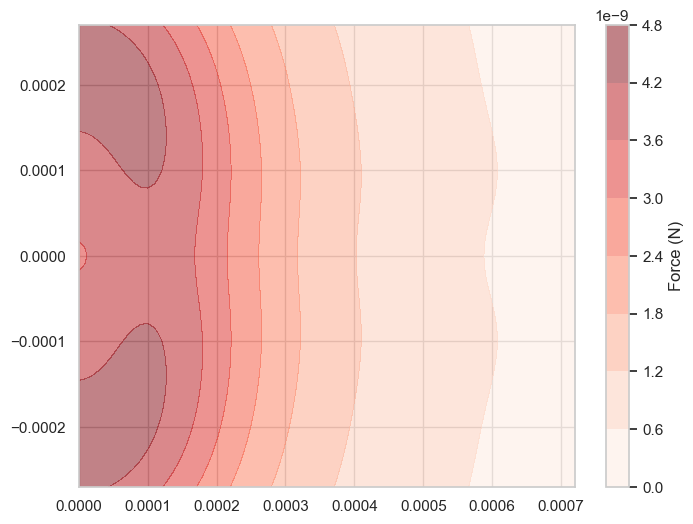

In [147]:
# Load

with h5py.File("./results/force_model.h5", "r") as f:
    force_control= f["model/force_field"][...]
    f2i = f["model/F2I"][...]
    x_axis = f["model/x"][...]
    y_axis = f["model/y"][...]
    i_axis = f["model/i"][...]

fig, ax = plt.subplots(figsize=(8,6))

CS = ax.contourf(x_axis, y_axis, force_control[:,:,level], alpha = 0.5, cmap = "Reds")
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Force (N)')